In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(lubridate)
library(TSSS)


Attaching package: ‘TSSS’


The following object is masked from ‘package:lubridate’:

    period




In [ ]:
library(flextable)

データの読み込み

In [ ]:
test = read.csv("/content/sample_data/test.csv", header = T)
train = read.csv("/content/sample_data/train.csv", header = T)

In [ ]:
print(length(train$date))
Item = train$item
Store = train$store
Sales = train$sales
print(range(Item))
print(range(Store))
print(range(Sales))

[1] 913000
[1]  1 50
[1]  1 10
[1]   0 231


In [ ]:
# Convert the 'date' column to date format
train$date <- as.Date(train$date)

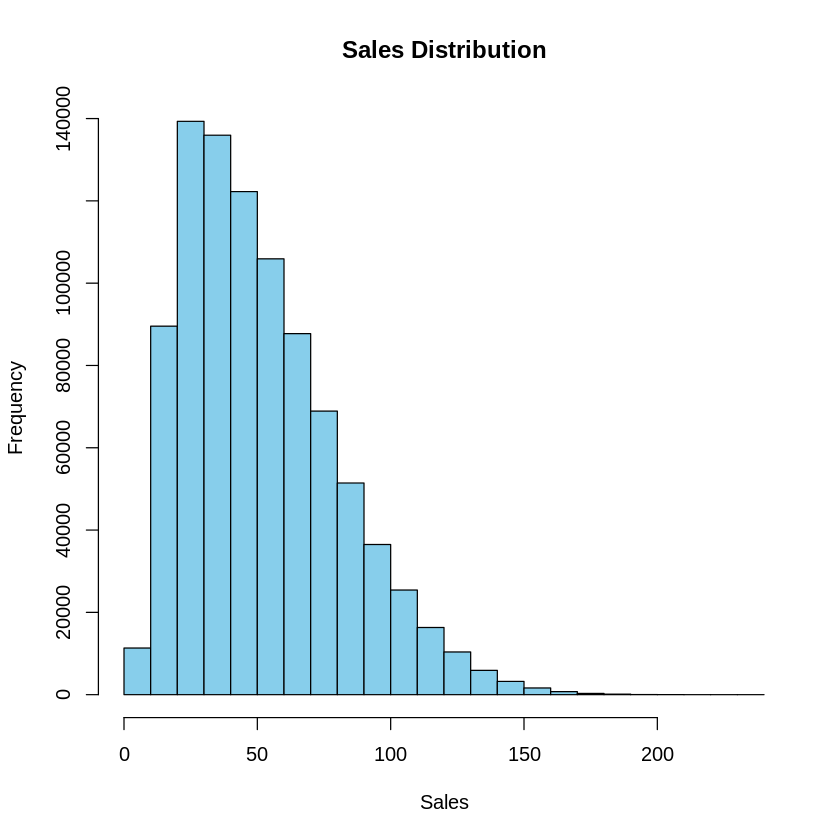

In [ ]:
# ヒストグラムを描画
hist(train$sales,
     breaks = 20,        # 棒の数（binsに相当）
     col = "skyblue",    # 棒の色
     border = "black",   # 枠線の色
     main = "Sales Distribution",  # タイトル
     xlab = "Sales",     # x軸ラベル
     ylab = "Frequency") # y軸ラベル

Pivotを用い、各店舗×商品の売上データ作成

In [ ]:
# store と item を組み合わせて列名用のラベルを作成
train <- train %>%
  mutate(store_item = paste0("store=", store, "&item=", item))

# pivot_wider で日付ごとに各 store×item の sales を列にする
df <- train %>%
  pivot_wider(
    id_cols = date,           # 行のインデックスにする列
    names_from = store_item,  # 列名にする列
    values_from = sales       # 値にする列
  )

# 結果確認
show_head_tail_console(df, n = 3, rows = 6)


date,store=1&item=1,store=2&item=1,...,store=8&item=50,store=9&item=50,store=10&item=50
<date>,<int>,<int>,<chr>,<int>,<int>,<int>
2013-01-01,13,12,...,45,36,33
2013-01-02,11,16,...,54,44,37
2013-01-03,14,16,...,54,29,46
2013-01-04,13,20,...,52,43,51
2013-01-05,10,16,...,48,53,41
2013-01-06,12,18,...,51,38,41


In [ ]:
head(train)

,date,store,item,sales,store_item
,<date>,<int>,<int>,<int>,<chr>
1,2013-01-01,1,1,13,store=1&item=1
2,2013-01-02,1,1,11,store=1&item=1
3,2013-01-03,1,1,14,store=1&item=1
4,2013-01-04,1,1,13,store=1&item=1
5,2013-01-05,1,1,10,store=1&item=1
6,2013-01-06,1,1,12,store=1&item=1


Sales of item=1

In [ ]:
# item=1 の列だけ抽出
item1_cols <- grep("item=1$", colnames(df), value = TRUE)
df_item1_total <- df %>%
  select(date, all_of(item1_cols)) %>%
  mutate(total_sales = rowSums(across(all_of(item1_cols))))%>%
  mutate(date = as.Date(date),
         weekday = weekdays(date))  # 曜日列を追加

In [ ]:
weekday

[1] "Tuesday"

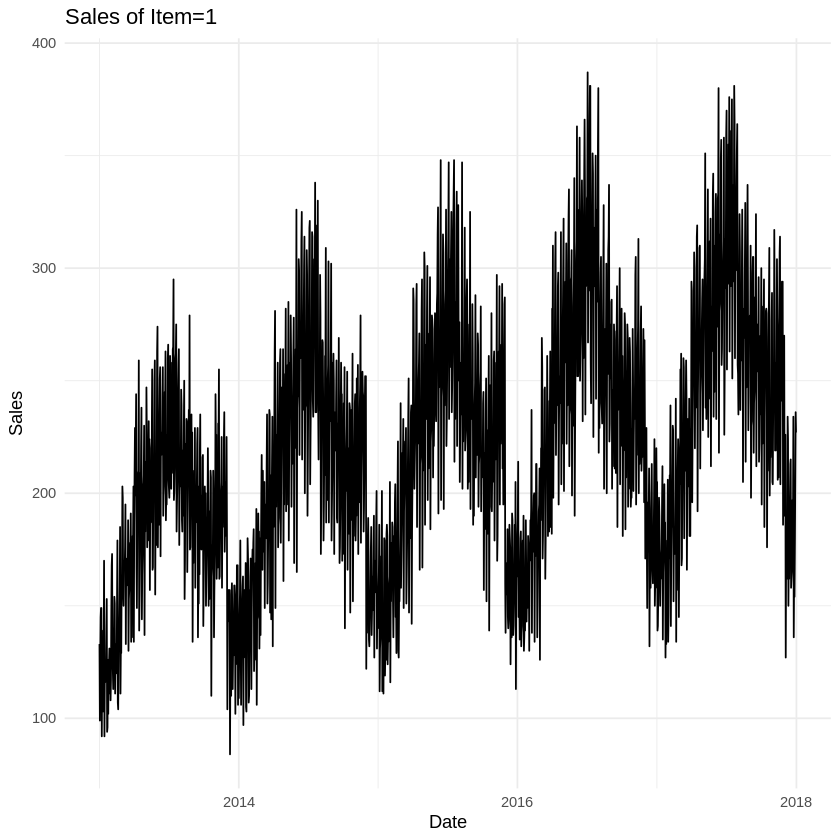

In [ ]:
# 折れ線グラフ（全店舗合計）
ggplot(df_item1_total, aes(x = date, y = total_sales)) +
  geom_line(color = "black") +
  labs(title = "Sales of Item=1", x = "Date", y = "Sales") +
  theme_minimal()


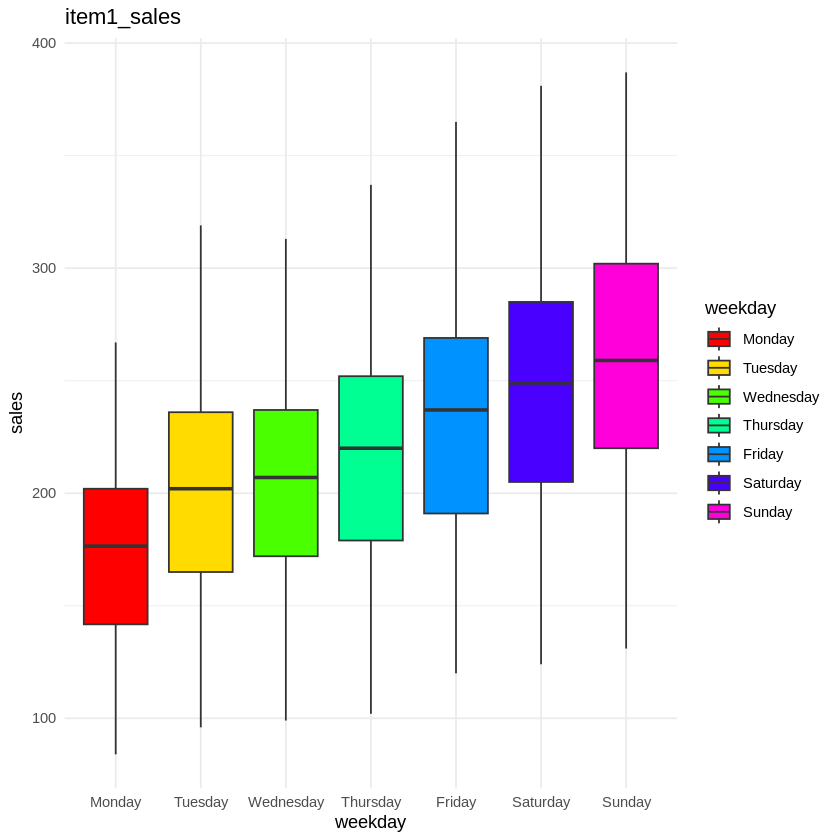

In [ ]:
# 曜日別箱ひげ図
df_item1_total <- df_item1_total %>%
  mutate(weekday = factor(weekday, levels = c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")))

ggplot(df_item1_total, aes(x = weekday, y = total_sales, fill = weekday)) +
  geom_boxplot() +
  scale_fill_manual(values = rainbow(7)) +
  labs(title = "item1_sales",
       x = "weekday", y = "sales") +
  theme_minimal()

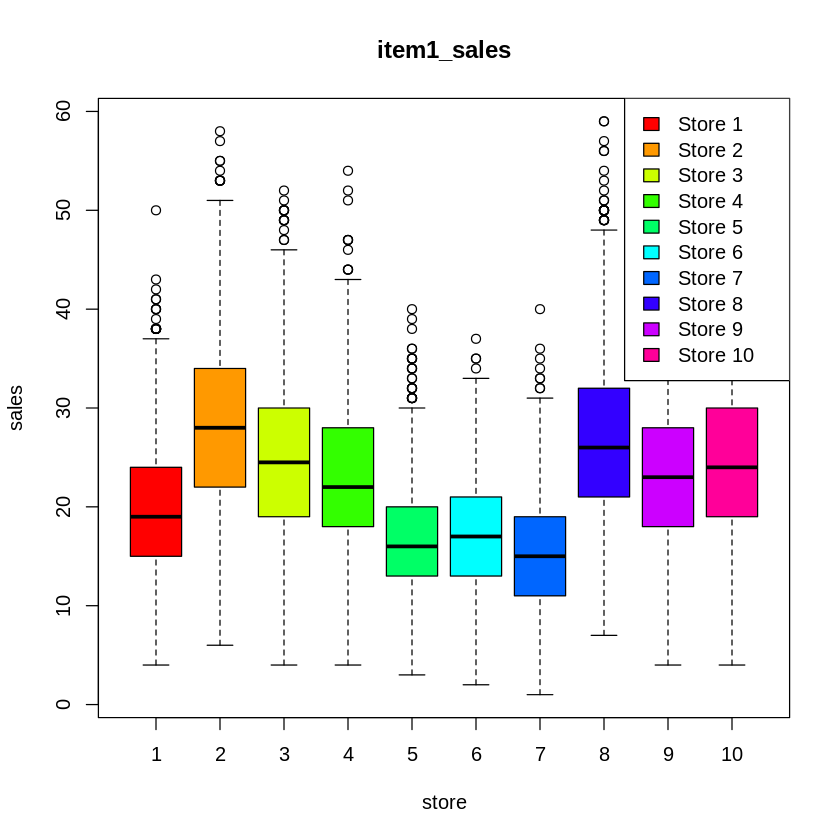

In [ ]:
# item=1 の列だけ抽出
item1_cols <- grep("item=1$", colnames(df), value = TRUE)
df_item1 <- df %>%
  select(date, all_of(item1_cols)) %>%
  pivot_longer(-date, names_to = "store", values_to = "sales")

# store 名を 1~10 に置換
df_item1 <- df_item1 %>%
  mutate(store = factor(1:length(unique(store)))[match(store, unique(store))])

# 箱ひげ図
boxplot(sales ~ store, data = df_item1,
        main = "item1_sales",
        xlab = "store",
        ylab = "sales",
        col = rainbow(10))
# 凡例
legend("topright", legend = paste("Store", 1:10), fill = rainbow(10))


自己相関・パワースペクトラム

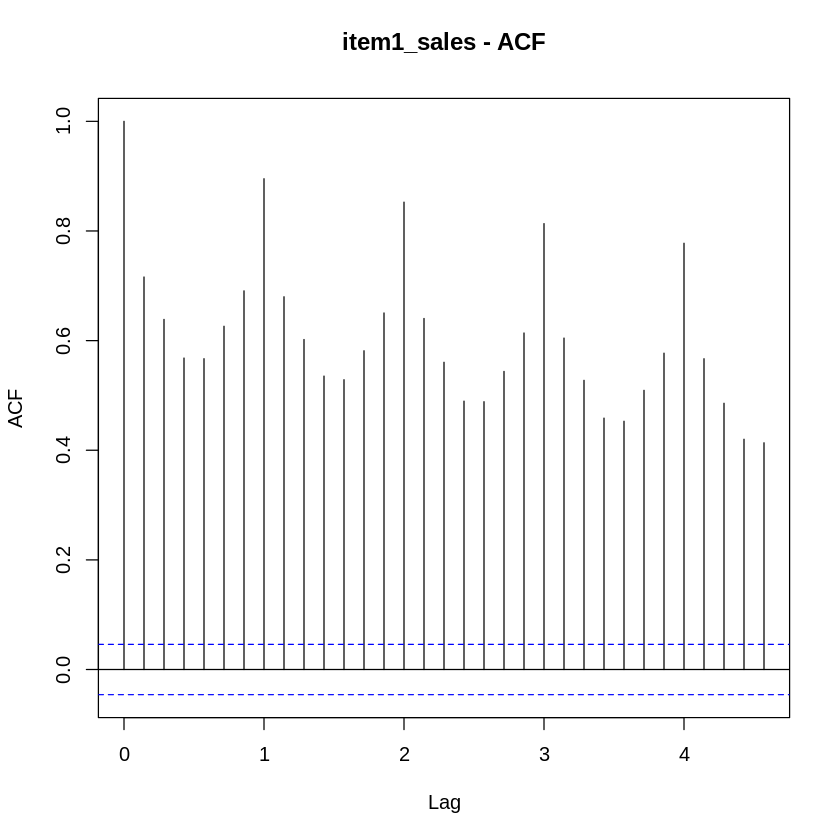

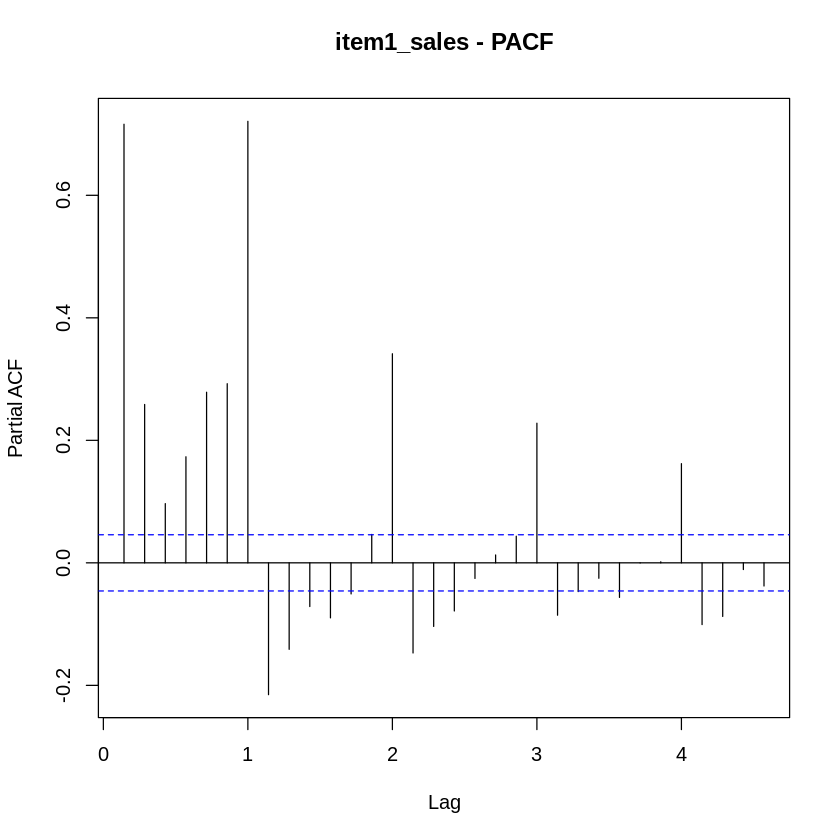

In [ ]:
# 時系列オブジェクトに変換（例：日次データ）
ts_item1 <- ts(df_item1_total$total_sales, frequency = 7)  # 週周期を仮定

# 自己相関プロット
acf(ts_item1, main = "item1_sales - ACF")

# 偏自己相関プロット
pacf(ts_item1, main = "item1_sales - PACF")

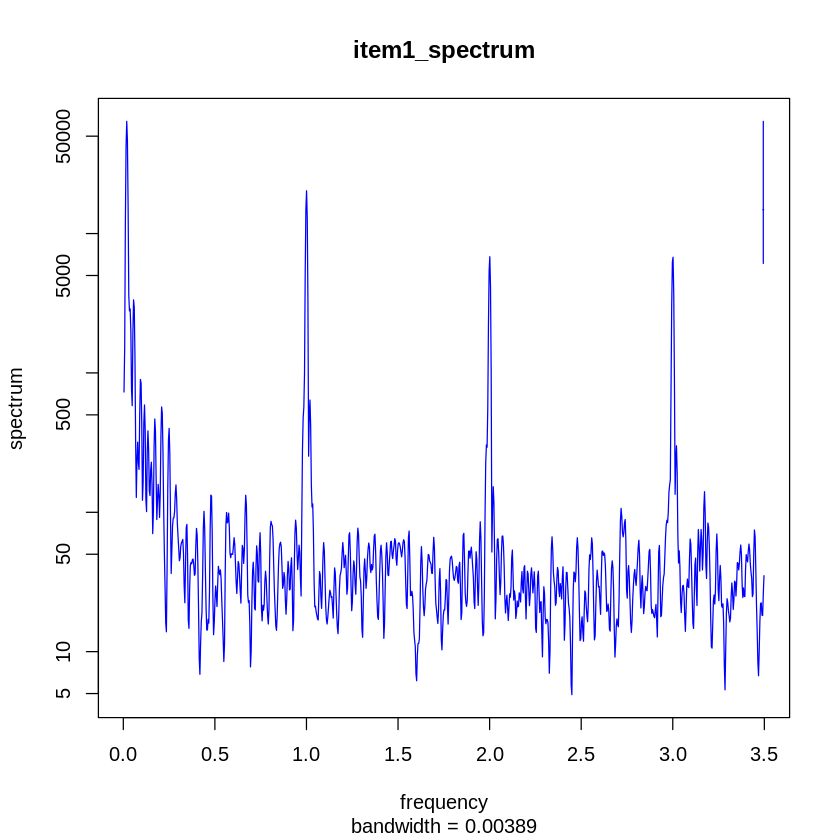

In [ ]:
# スペクトル密度（periodogram）を描く
spectrum(ts_item1,
         main = "item1_spectrum",
         spans = c(3,3),  # 平滑化
         col = "blue")

[1] 219.816

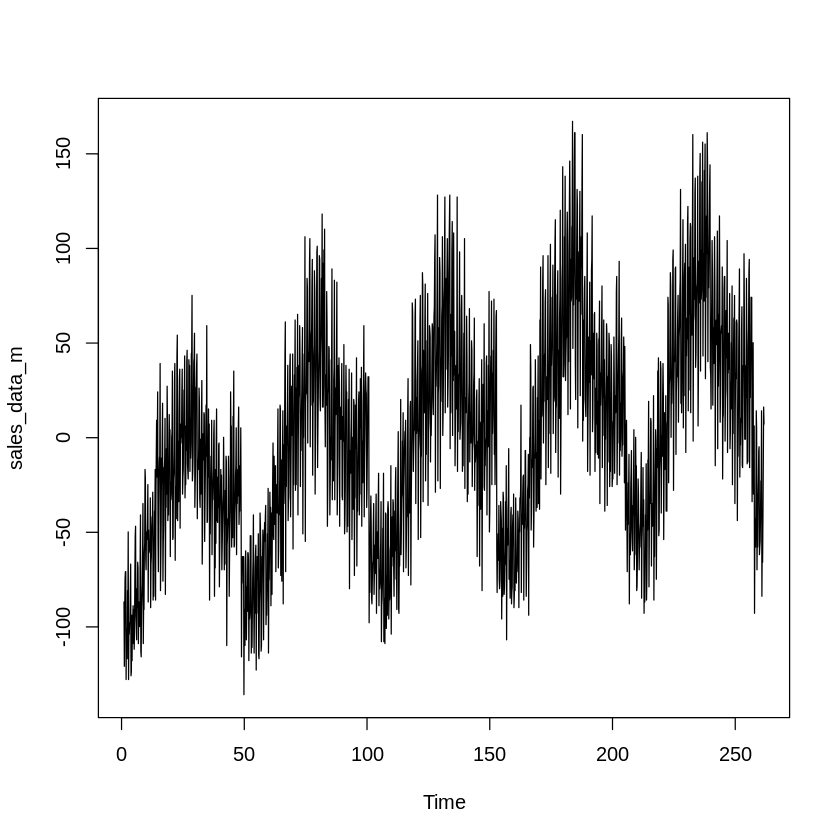

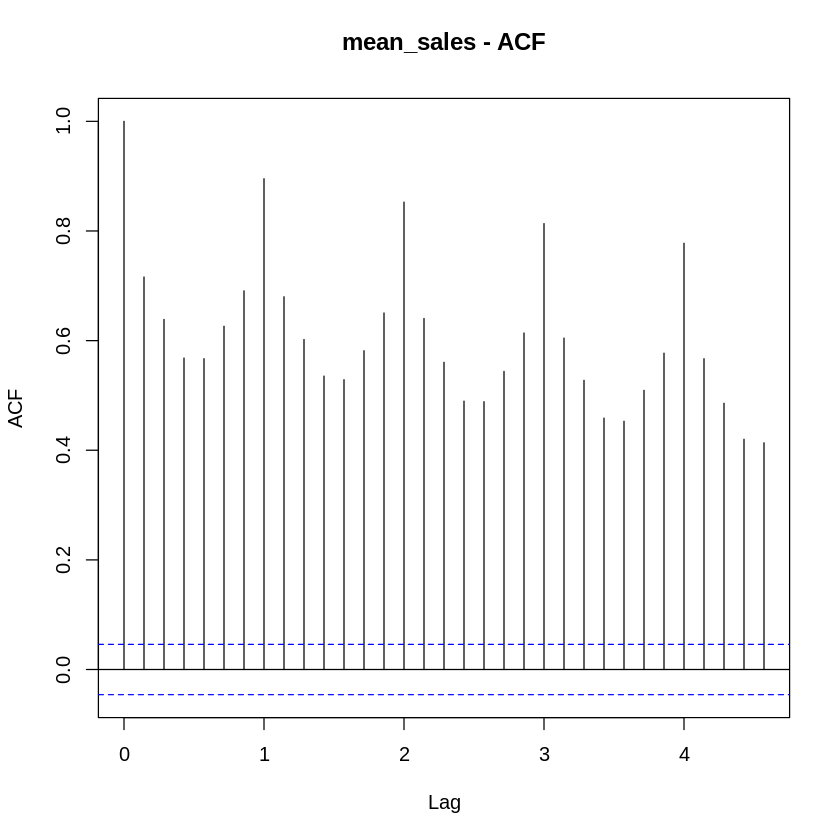

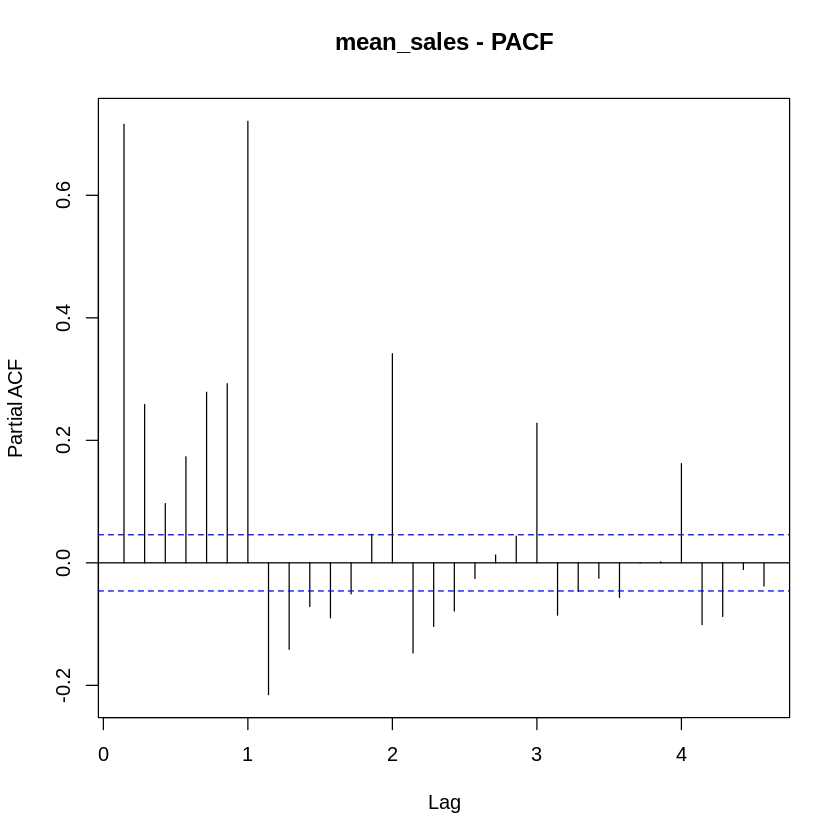

In [ ]:
# 平均値を引いた時系列データの作成
# 売上データの平均値を計算
mean_sales <- mean(ts_item1, na.rm = TRUE)
mean_sales

# 平均値を引いた時系列データ
sales_data_m <- ts_item1 - mean_sales
plot(sales_data_m, type="l")

# 平均値を引いたデータの自己相関関数 (ACF) のプロット
acf(sales_data_m, main = "mean_sales - ACF")

# 平均値を引いたデータの偏自己相関関数 (PACF) のプロット
pacf(sales_data_m, main = "mean_sales - PACF")


ペリオドグラム

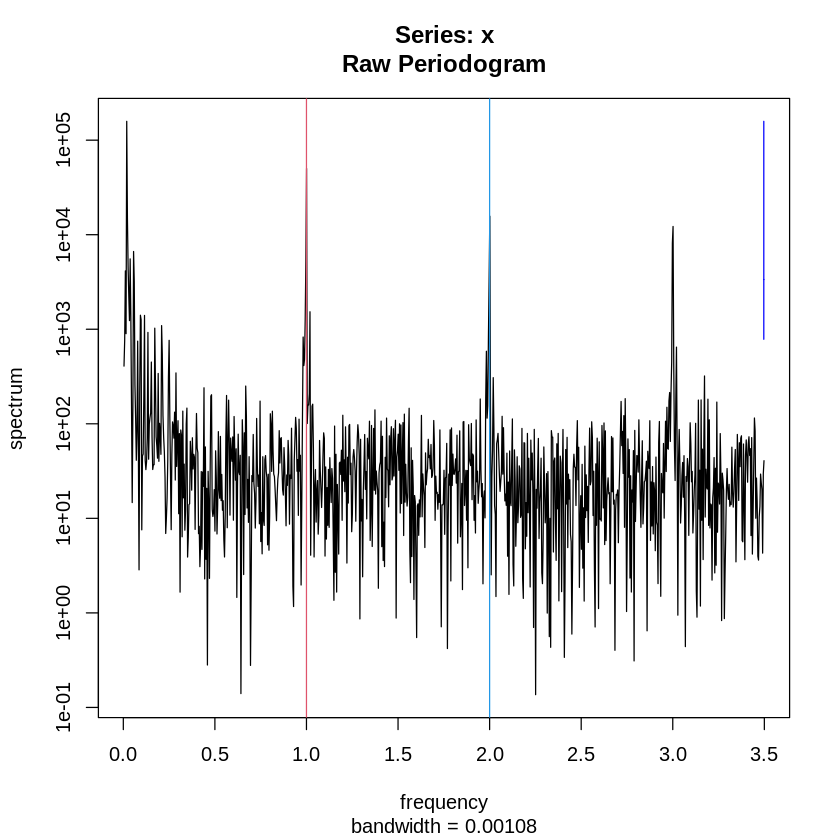

In [ ]:
spectrum(sales_data_m,method="pgram")
abline(v=1,col=2)
abline(v=2,col=4)

パワースペクトラム：AR法

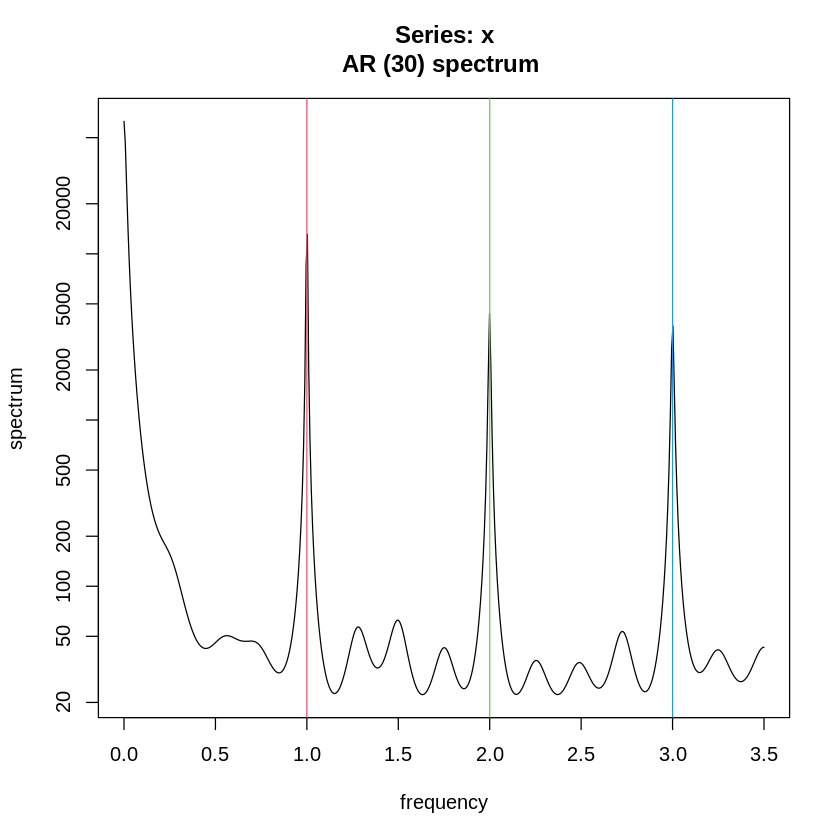

In [ ]:
spectrum(sales_data_m,method="ar")
abline(v=1,col=2)
abline(v=2,col=3)
abline(v=3,col=4)

In [ ]:
# FFT をかける
fft_result <- fft(sales_data_m)
# print(length(sales_data_m))
N_ps <- length(fft_result)/2

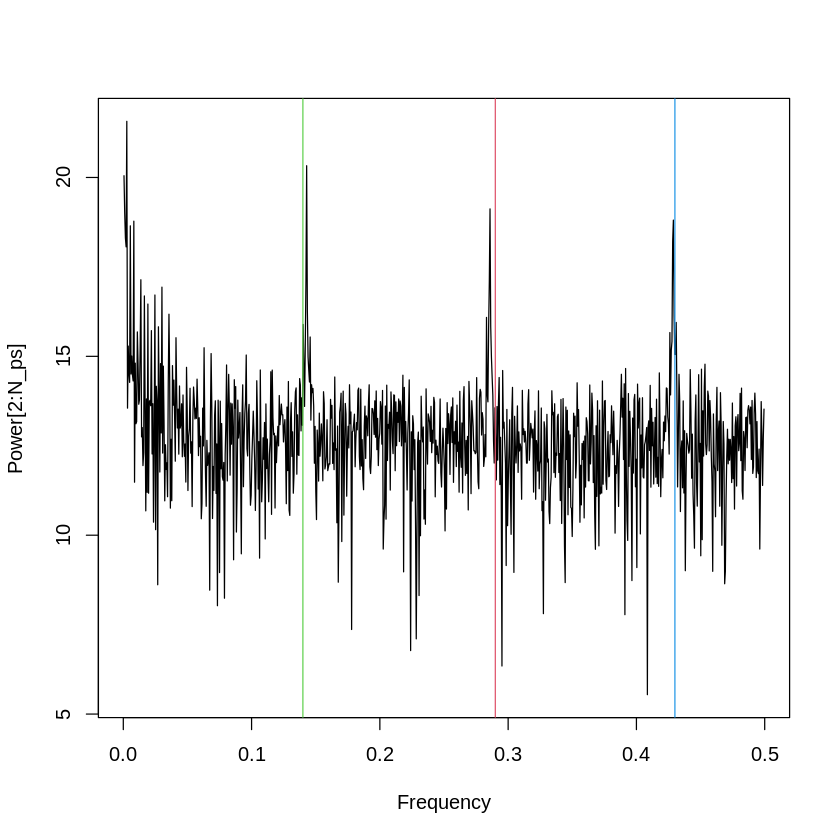

In [ ]:
Power <- log( Mod(fft_result)^2 )
freq <- (seq(1:(N_ps-1))/N_ps)*0.5
# print(length(Power))
plot(freq, Power[2:N_ps],type='l', xlab='Frequency')
abline(v=0.14,col=3)
abline(v=0.29,col=2)
abline(v=0.43,col=4)

Boxcox


 lambda    aic'         LL'         aic          LL        mean
           variance

  1.00    19910.59    -9953.30    19910.59    -9953.30   1.358160e+02   3.177564e+03

  0.90    19888.25    -9942.12    18130.70    -9063.35   9.109087e+01   1.198854e+03

  0.80    19875.91    -9935.95    16360.81    -8178.40   6.176293e+01   4.547962e+02

  0.70    19874.33    -9935.16    14601.68    -7298.84   4.239217e+01   1.735508e+02

  0.60    19884.42    -9940.21    12854.22    -6425.11   2.949628e+01   6.665188e+01

  0.50    19907.30    -9951.65    11119.56    -5557.78   2.083608e+01   2.577751e+01

  0.40    19944.42    -9970.21     9399.12    -4697.56   1.496474e+01   1.004739e+01

  0.30    19997.65    -9996.83     7694.81    -3845.40   1.094259e+01   3.950947e+00

  0.20    20069.65   -10032.83     6009.25    -3002.63   8.155902e+00   1.569677e+00

  0.10    20164.19   -10080.10     4346.25    -2171.12   6.201440e+00   6.313676e-01

  0.00    20286.95   -10141.47     2711.45    -1353.73

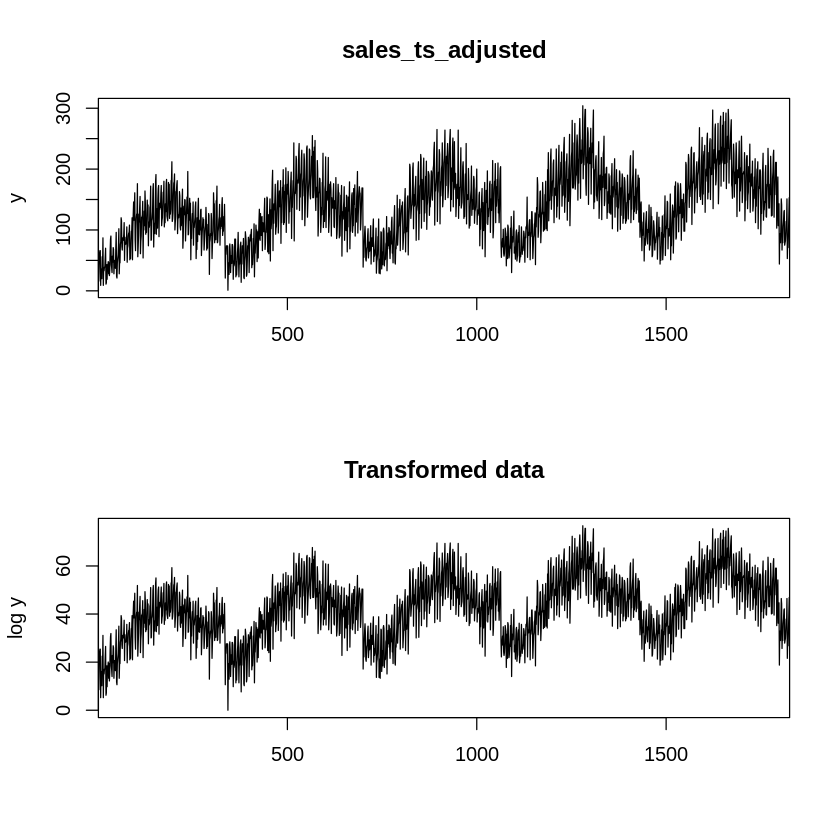

In [ ]:
# Check for minimum value and add a constant if necessary for Box-Cox
min_sales_data_m = min(sales_data_m, na.rm = TRUE)
if (min_sales_data_m <= 0) {
  # Add a constant slightly larger than the absolute value of the minimum
  sales_data_m_adjusted = sales_data_m + abs(min_sales_data_m) + 1
} else {
  sales_data_m_adjusted = sales_data_m
}


# ts()関数を使って時系列オブジェクトに変換
# データの観測頻度は週単位であるため、frequencyは1
sales_ts_adjusted = ts(sales_data_m_adjusted, frequency = 1)

# tsオブジェクトに変換したデータでboxcox()を実行
boxcox(sales_ts_adjusted)

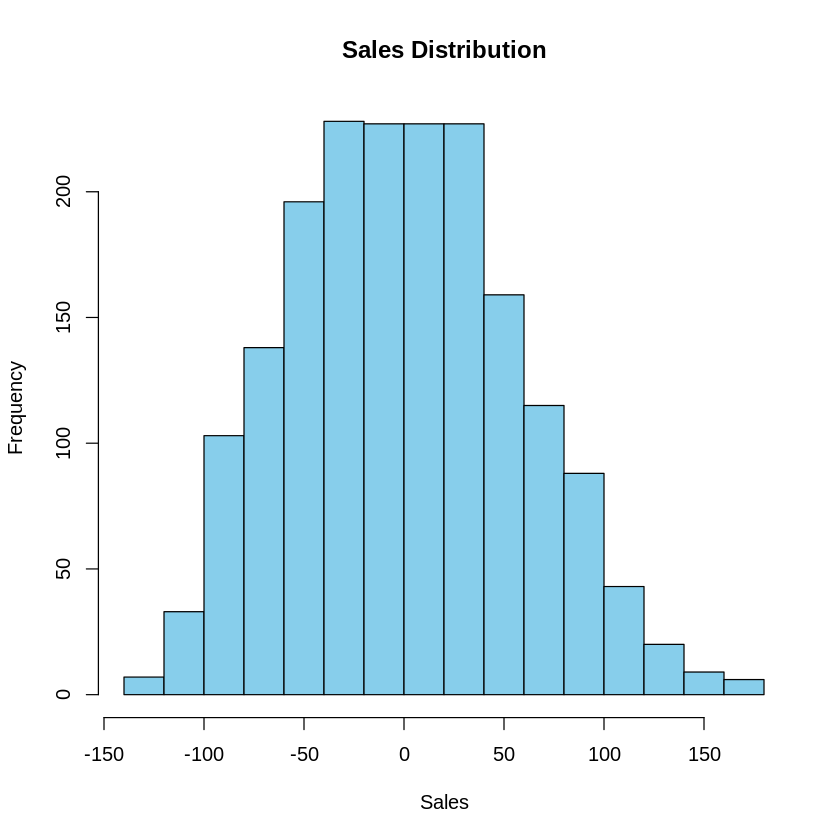

In [ ]:
# ヒストグラムを描画
hist(sales_data_m,
     breaks = 20,        # 棒の数（binsに相当）
     col = "skyblue",    # 棒の色
     border = "black",   # 枠線の色
     main = "Sales Distribution",  # タイトル
     xlab = "Sales",     # x軸ラベル
     ylab = "Frequency") # y軸ラベル

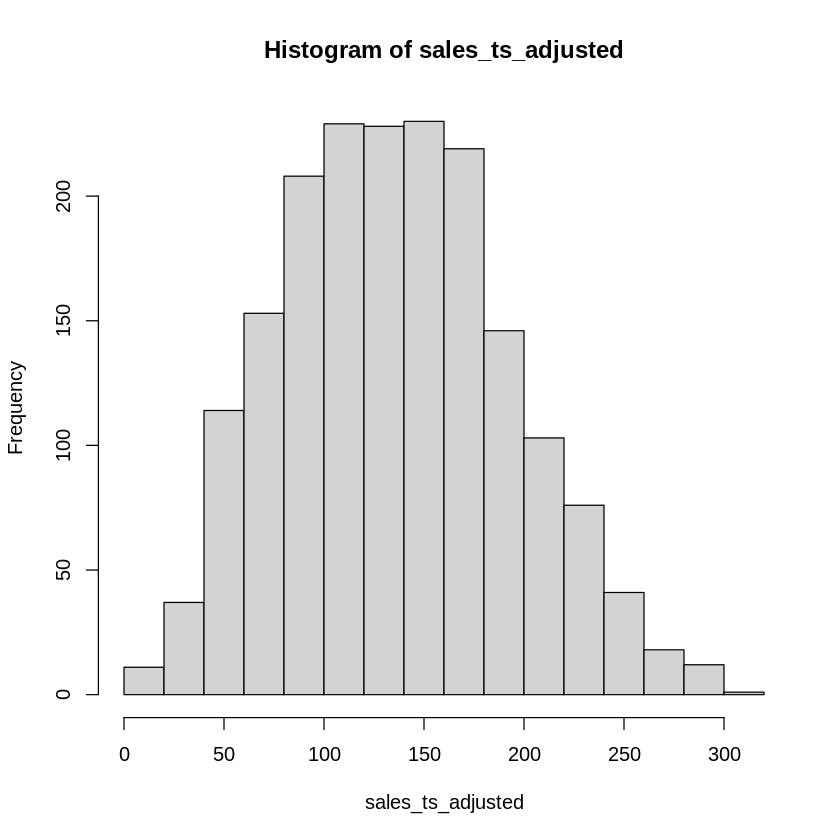

In [ ]:
hist(sales_ts_adjusted)

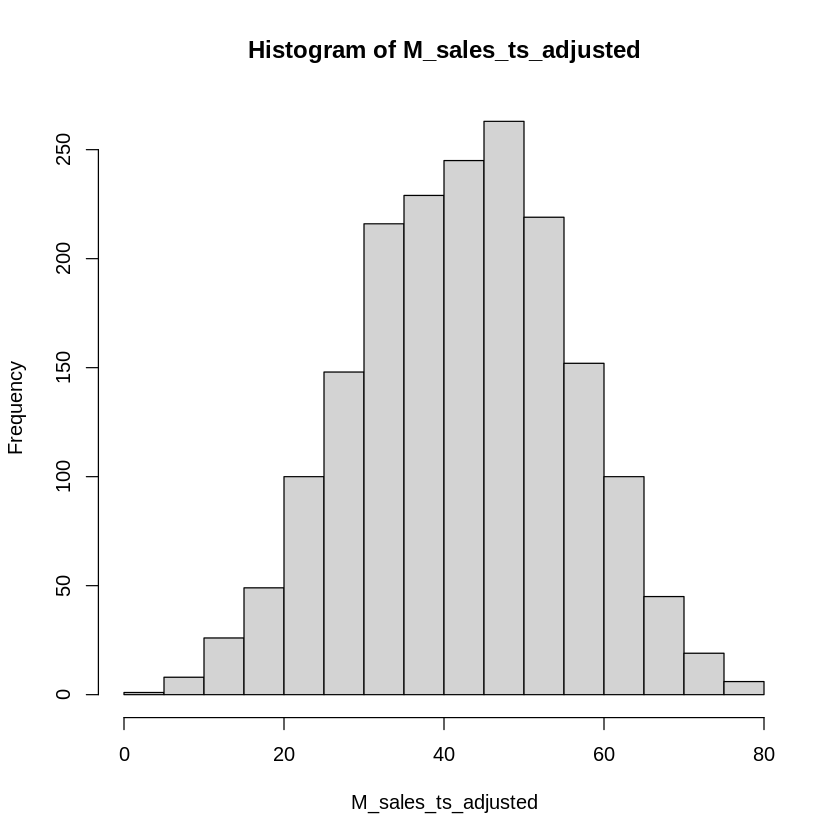

In [ ]:
L_Best = 0.7
M_sales_ts_adjusted =(sales_ts_adjusted^L_Best - 1.0) / L_Best
hist(M_sales_ts_adjusted)

時系列分解

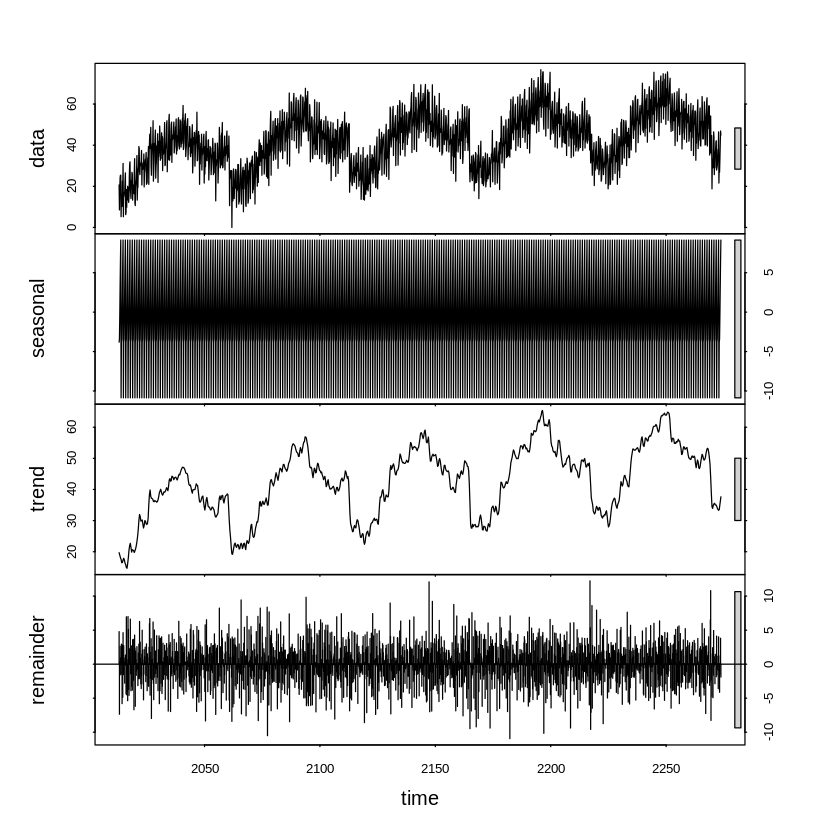

In [ ]:
# 1. Box-Cox変換後のデータを時系列オブジェクトに変換
# データの頻度（frequency）を週周期（7）に設定
# 例：データが2013年1月1日から始まると仮定
# 実際のデータの開始日と頻度に合わせて調整してください
sales_ts <- ts(M_sales_ts_adjusted, start = c(2013, 1), frequency = 7)

# 2. STL分解の実行
# s.window="periodic"で季節成分を周期的にロバストに推定
stl_decomposition <- stl(sales_ts, s.window = "periodic")

# 3. 分解結果のプロット
plot(stl_decomposition)

# 4. 各成分の抽出
# トレンド成分
trend_component <- stl_decomposition$time.series[, "trend"]

# 季節成分
seasonal_component <- stl_decomposition$time.series[, "seasonal"]

# 残差成分
remainder_component <- stl_decomposition$time.series[, "remainder"]

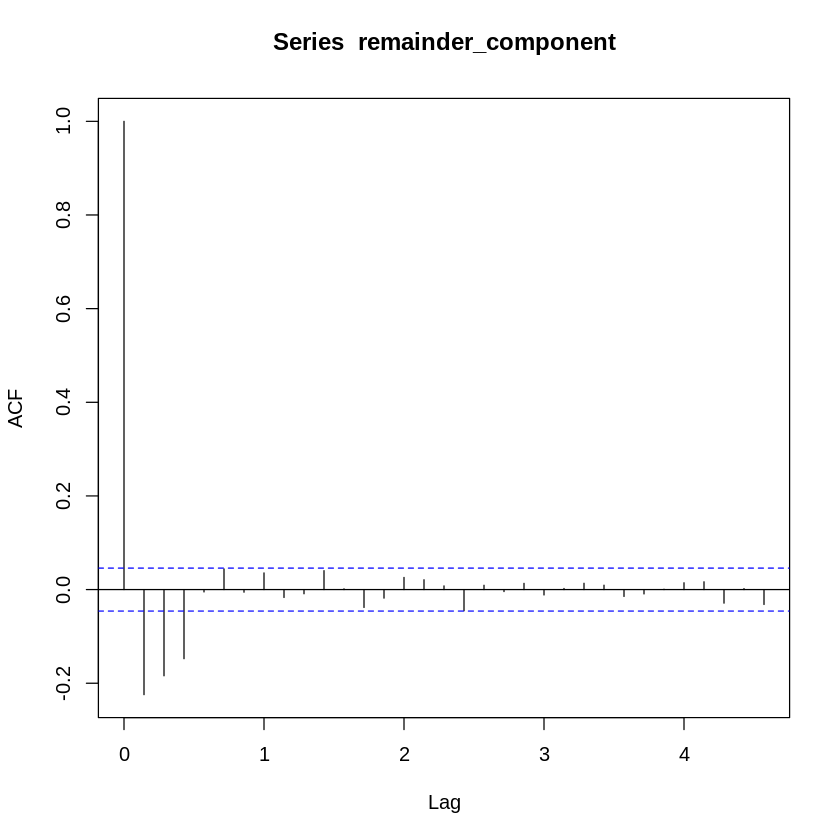

In [ ]:
acf(remainder_component)

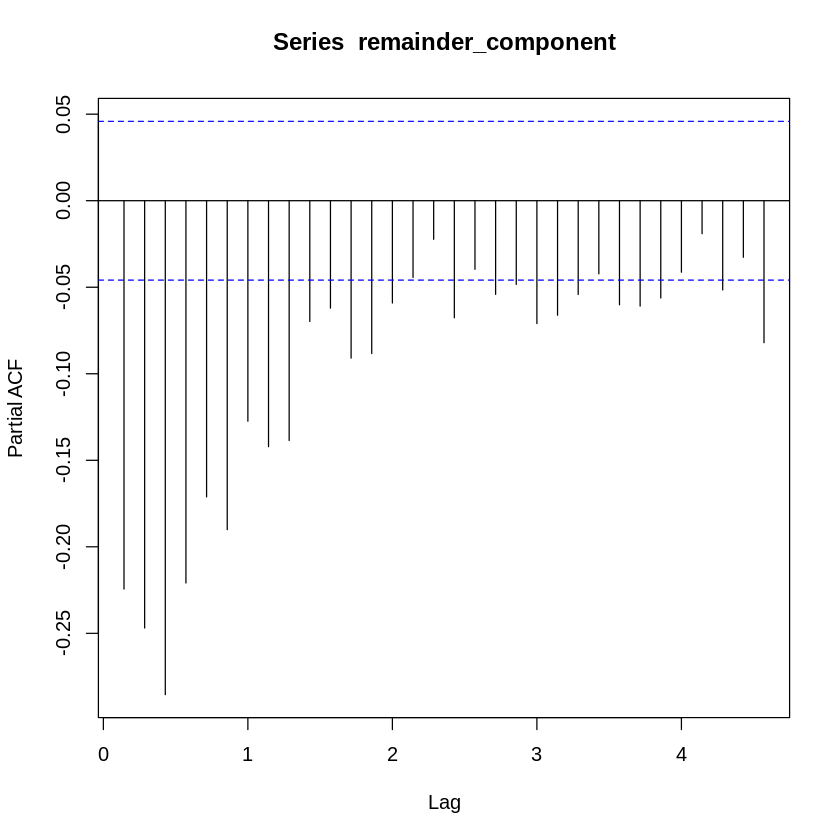

In [ ]:
pacf(remainder_component)


Call:
arima(x = sales_ts, order = c(0, 0, 1), seasonal = list(order = c(0, 0, 0), 
    period = 7))

Coefficients:
         ma1  intercept
      0.5271    42.3912
s.e.  0.0181     0.3845

sigma^2 estimated as 115.8:  log likelihood = -6929.65,  aic = 13865.31


Warning message in arima(sales_ts, order = c(0, 0, 1), seasonal = list(order = c(1, :
“possible convergence problem: optim gave code = 1”



Call:
arima(x = sales_ts, order = c(0, 0, 1), seasonal = list(order = c(1, 0, 1), 
    period = 7))

Coefficients:
         ma1    sar1     sma1  intercept
      0.2924  0.9680  -0.4442    41.1788
s.e.  0.0193  0.0066   0.0232     2.4490

sigma^2 estimated as 26.51:  log likelihood = -5589.87,  aic = 11189.73


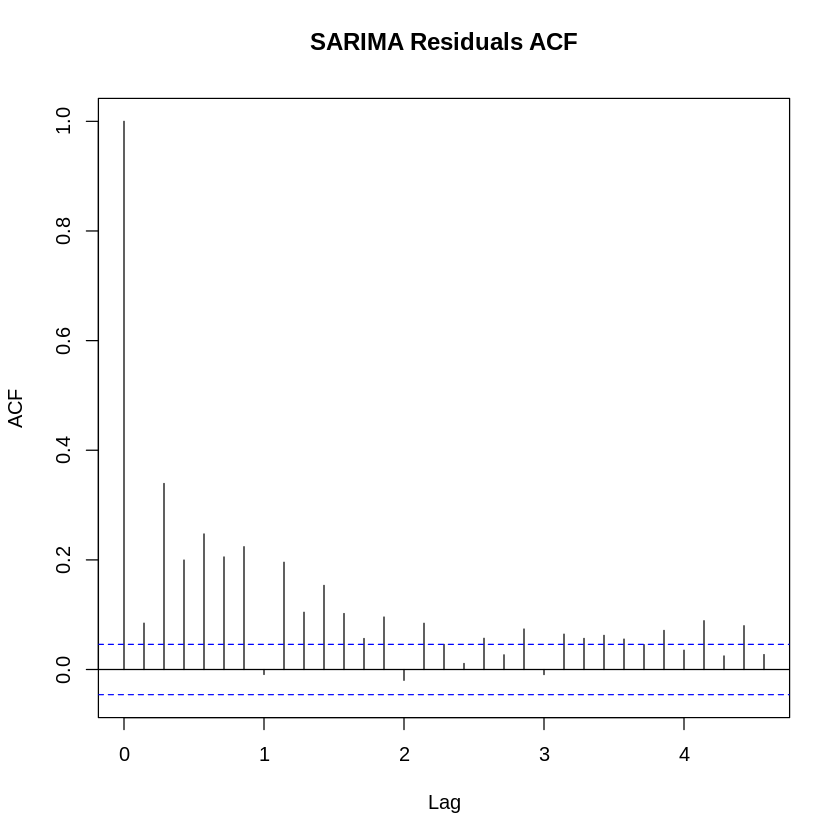


	Box-Ljung test

data:  model_s1$residuals
X-squared = 754.63, df = 14, p-value < 2.2e-16


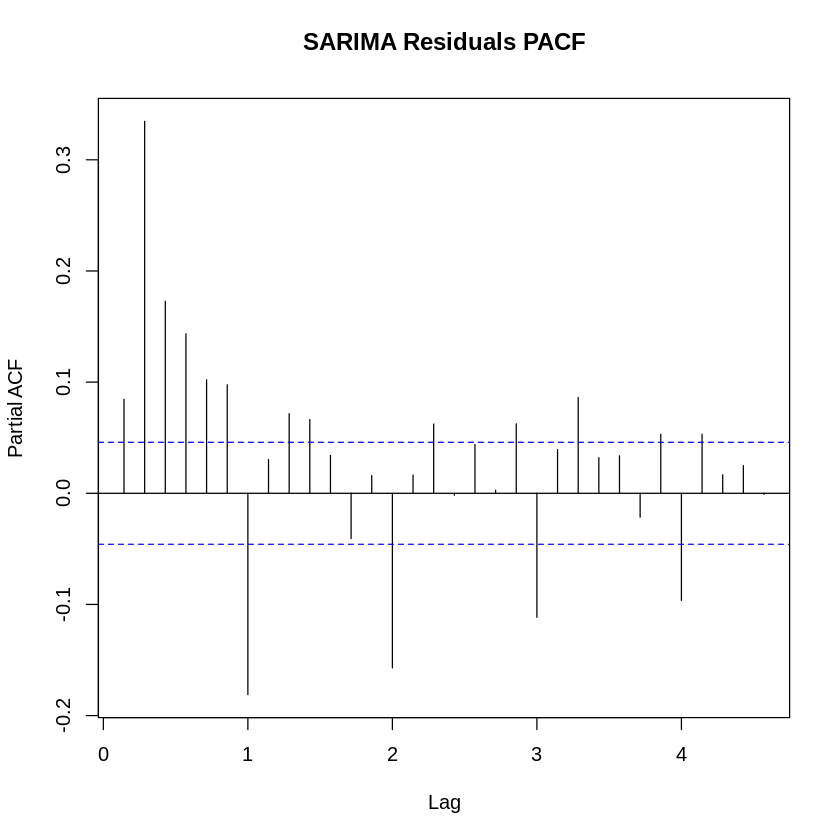

In [ ]:
# Box-Cox変換後のデータを時系列オブジェクトとして再確認 (frequency=7)
# ts_data_boxcox は Box-Cox変換後のデータが入っているとする

# -----------------------------------------------------
# 【モデル1: 最もシンプルなSARIMAモデルを適用】
# SARIMA(0, 0, 1) x (0, 0, 0)_7
# 季節項は0とし、非季節のMA(1)のみを考慮
# -----------------------------------------------------
model_s0 <- arima(sales_ts,
                  order = c(0, 0, 1),
                  seasonal = list(order = c(0, 0, 0), period = 7))

# 結果の表示（AIC/BIC、係数、p値などを確認）
print(model_s0)

# -----------------------------------------------------
# 【モデル2: 季節項を考慮した一般的なSARIMAモデルを試す】
# SARIMA(0, 0, 1) x (1, 0, 1)_7
# 季節性のAR(1)とMA(1)を考慮
# -----------------------------------------------------
model_s1 <- arima(sales_ts,
                  order = c(0, 0, 1),
                  seasonal = list(order = c(1, 0, 1), period = 7))

# 結果の表示とAICの比較
print(model_s1)

# AICがより小さいモデルを選択し、以下の診断へ進む

# -----------------------------------------------------
# 【モデル診断（必ず行うべき工程）】
# -----------------------------------------------------

# 1. 残差の自己相関の確認 (残差がホワイトノイズであるかをチェック)
acf(model_s1$residuals, main = "SARIMA Residuals ACF")
pacf(model_s1$residuals, main = "SARIMA Residuals PACF")

# 2. Ljung-Box検定 (残差に相関が残っていないかを統計的に検定)
# lag = 2 * period = 14程度を目安に設定
Box.test(model_s1$residuals, lag = 14, type = "Ljung-Box")


Call:
arima(x = sales_ts, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 7))

Coefficients:
          ma1     sma1
      -0.7036  -0.9961
s.e.   0.0161   0.0111

sigma^2 estimated as 17.5:  log likelihood = -5198.15,  aic = 10402.3


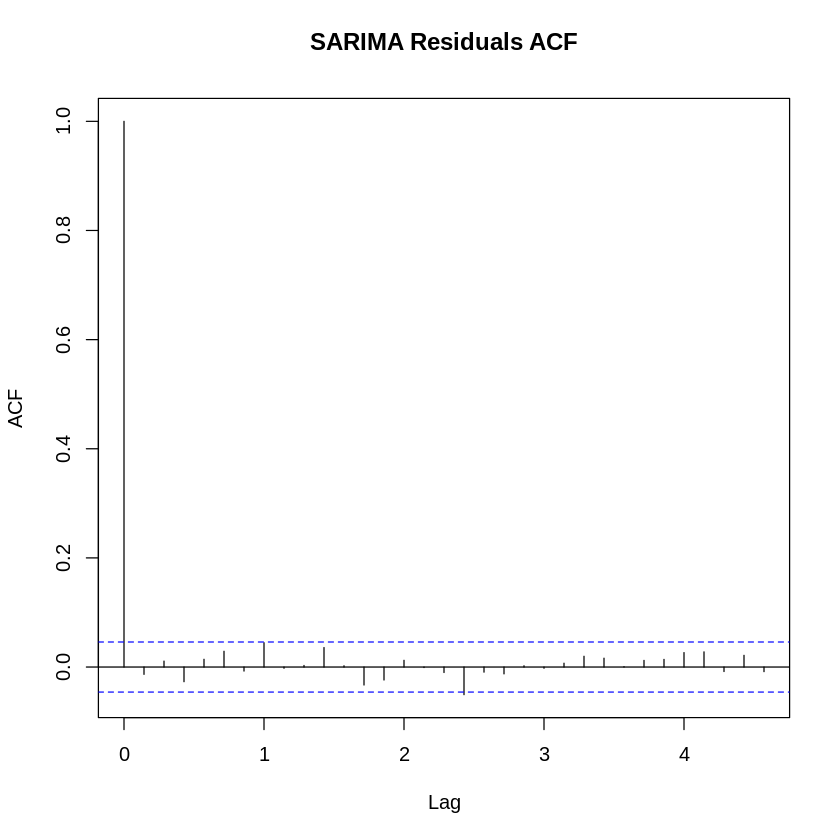


	Box-Ljung test

data:  model_s1$residuals
X-squared = 13.172, df = 14, p-value = 0.513


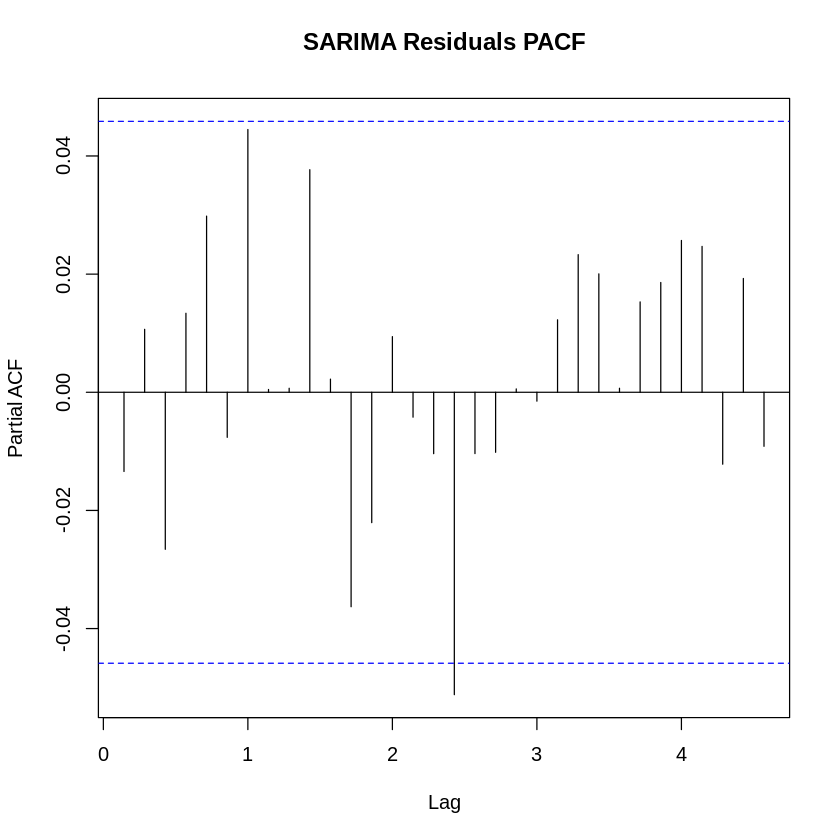

In [ ]:
# -----------------------------------------------------
# 【モデル3: 季節項を考慮した一般的なSARIMAモデルを試す】
# SARIMA(0, 1, 1) x (0, 1, 1)_7
# -----------------------------------------------------
model_s1 <- arima(sales_ts,
                  order = c(0, 1, 1),
                  seasonal = list(order = c(0, 1, 1), period = 7))

# 結果の表示とAICの比較
print(model_s1)

# AICがより小さいモデルを選択し、以下の診断へ進む

# -----------------------------------------------------
# 【モデル診断（必ず行うべき工程）】
# -----------------------------------------------------

# 1. 残差の自己相関の確認 (残差がホワイトノイズであるかをチェック)
acf(model_s1$residuals, main = "SARIMA Residuals ACF")
pacf(model_s1$residuals, main = "SARIMA Residuals PACF")

# 2. Ljung-Box検定 (残差に相関が残っていないかを統計的に検定)
# lag = 2 * period = 14程度を目安に設定
Box.test(model_s1$residuals, lag = 14, type = "Ljung-Box")

In [ ]:
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




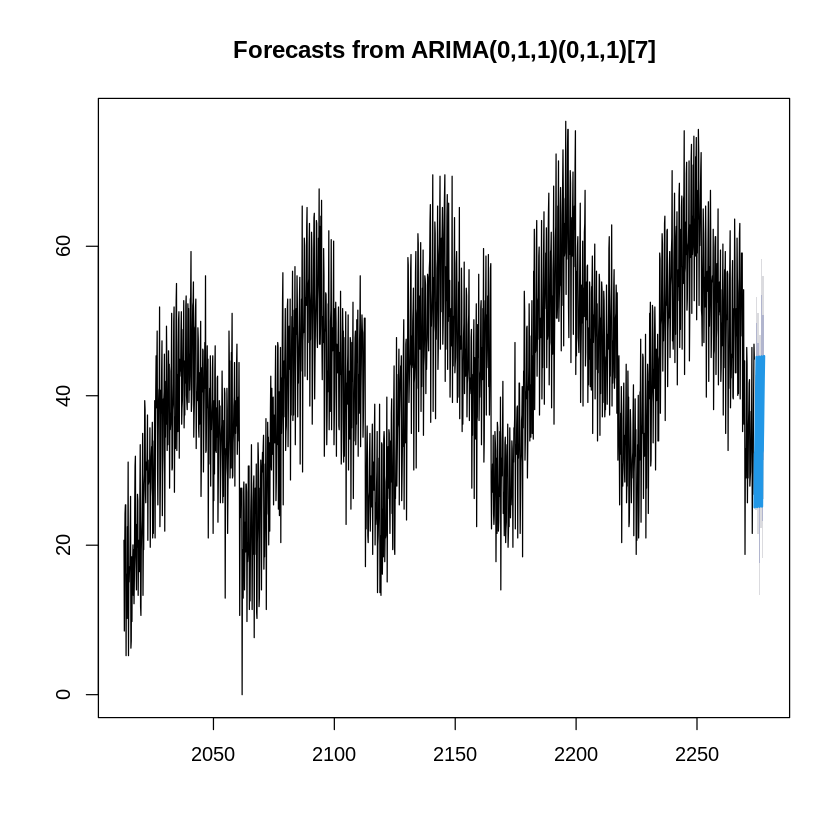

In [ ]:
# 決定したモデル（model_s1）を使って、次の期間の値を予測する
# hは予測したい期間の長さ（例: 4週間先まで予測する場合は h=28）
library(forecast)
forecast_result <- forecast(model_s1, h = 28)

# 予測結果をプロット
plot(forecast_result)

# 予測結果を元のスケール（Box-Cox変換前）に戻す処理が必要
# 予測値と信頼区間に対して、Box-Cox変換の逆変換（lambda=0.7）を適用する